<a href="https://colab.research.google.com/github/LinaDanilina/recommender-system/blob/master/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
%cd drive/My Drive/recommenders

[Errno 2] No such file or directory: 'drive/My Drive/recommenders'
/content/drive/My Drive/recommenders


In [16]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.2'

In [17]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix


from reco_utils.dataset import movielens
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Pandas version: 1.0.3


In [0]:
data=pd.read_csv('data.csv')
data=data[['user_id','movie_id','rating','unix_timestamp']]
data=data.rename(columns={'user_id':'userID','movie_id':'movieID','unix_timestamp':'timestamp'})
# Convert to 32-bit in order to reduce memory consumption 
data.loc[:, 'rating'] = data['rating'].astype(np.int32) 

In [0]:
X=pd.read_csv('rating.csv')
X=X.values
X=X.astype(np.int32) 

In [0]:
X=X[:,1:]

The method also returns informations on the sparsness of the dataset and the size of the user/affinity matrix. The former is given by the ratio between the unrated elements and the total number of matrix elements. This is what makes a recommendation task hard: we try to predict 93% of the missing data with only 7% of information!

We split the matrix using the default ration of 0.75, i.e. 75% of the ratings will constitute the train set.

In [0]:
Xtr, Xtst = numpy_stratified_split(X)

In [46]:
print(Xtr.shape)
print(Xtst.shape)

(943, 1682)
(943, 1682)



The splitter returns:

* Xtr: a matrix containing the train set ratings
* Xtst: a matrix containing the test elements

The model has been implemented as a Tensorflow (TF) class. TF does not support probabilistic models natively, so the implementation of the algorithm has a different structure than the one you may be used to see in popular supervised models. The class has been implemented in such a way that the TF session is hidden inside the fit() method and no explicit call is needed. The algorithm operates in three different steps:

* Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. Other parameters can be optionally tweaked for experimentation and to achieve better performance, as explained in the RBM Deep Dive section.

* Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained only on the training set, the test set is used to display the generalization accuracy of the trained model, useful to have an idea of how to fix the hyper parameters.

* Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined score. The prediction is then returned in a dataframe format ready to be analysed and deployed.

In [0]:
#First we initialize the model class
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



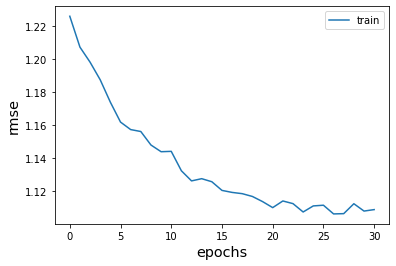

In [56]:
#Model Fit
train_time= model.fit(Xtr, Xtst)


During training, we can optionlly evauate the root mean squared error to have an idea of how the learning is proceeding. We would generally like to see this quantity decreasing as a function of the learning epochs. To visualise this choose with_metrics = True in the RBM() model function.

Once the model has been trained, we can predict new ratings on the test set.

In [0]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k, test_time =  model.recommend_k_items(Xtst)

In [0]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [59]:
top_k_df.head(10)

,userID,movieID,prediction
0,1,86,4.601876
1,1,124,4.752877
2,1,208,4.727682
3,1,304,4.604753
4,1,916,4.902136
5,1,1099,4.878139
6,1,1591,4.603072
7,1,1571,4.567095
8,1,1623,4.686572
9,1,1624,4.759846


In [0]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)
    rmse_=rmse(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction")
    mae_=mae(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction")
    r2=rsquared(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction")
    ex_var=exp_var(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction")
    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "RMSE": rmse_,
            "MAE": mae_,
            "R2": r2,
            "EXP VAR": ex_var,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [61]:
eval_100k= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df,
    data_pred =top_k_df,
    time_train=train_time,
    time_test =test_time,
    K =10)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,RMSE,MAE,R2,EXP VAR,Train time (s),Test time (s)
0,mv 100k,10,0.150285,0.434672,0.351644,0.218246,0.824665,0.602413,-0.296868,0.037369,3.374783,0.403583
